In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:


# === 1. Загружаем пример изображения ===
# (Можно заменить на своё изображение)
image = cv2.imread("Lenna.jpg", cv2.IMREAD_GRAYSCALE)



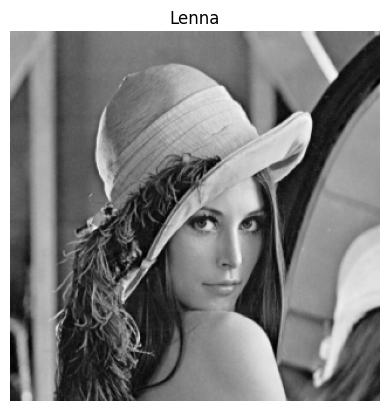

In [ ]:
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title('Lenna')
plt.show()

In [ ]:
h, w = image.shape
def show(title, img):
    plt.figure(figsize=(4,4))
    plt.title(title)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

Мы выполняем жёсткое преобразование изображения, которое включает только поворот и перенос. Используются следующие параметры:

Угол поворота: angle = 30° — изображение вращается на 30 градусов вокруг своего центра.

Сдвиг по горизонтали: tx = 40 пикселей — изображение перемещается вправо.

Сдвиг по вертикали: ty = 20 пикселей — изображение дополнительно смещается вниз на 20 пикселей.

Центр поворота: (w/2, h/2) — вращение выполняется относительно центра кадра.

Rigid-преобразование не изменяет форму объектов: оно меняет только ориентацию и положение изображения, без масштабирования и без деформации.

1. Функция для создания матрицы поворота:

getRotationMatrix2D(center, angle, scale)

Эта функция формирует аффинную матрицу 2×3, которая отвечает за поворот изображения вокруг заданной точки.
Мы передаём:

center — центр вращения (w/2, h/2)

angle — угол в градусах (здесь 30°)

scale — коэффициент масштабирования (в rigid-преобразовании он равен 1: масштаб не меняется)

Результат — матрица, которая поворачивает изображение вокруг его центра.

2. Добавление переноса (translation)

После создания матрицы поворота в неё вручную добавляются значения tx и ty.
Это изменяет третий столбец матрицы и означает:

+40 пикселей по оси X,

+20 пикселей по оси Y.

Таким образом, мы совмещаем поворот и сдвиг в одном преобразовании.

3. Применение аффинного преобразования:

warpAffine(image, M, output_size)

Эта функция «применяет» матрицу преобразования M к каждому пикселю изображения. OpenCV вычисляет, куда должен переместиться каждый пиксель, используя полученную матрицу rigid-трансформации.

Мы указываем:

исходное изображение,

матрицу 2×3 (поворот + перенос),

размер выходного изображения.

На выходе получаем изменённую версию входного изображения.

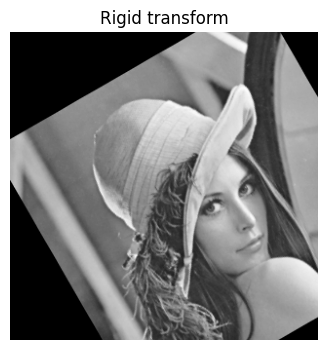

In [ ]:
# Rotation + Translation (rigid)
angle = 30
tx, ty = 40, 20

M_rigid = cv2.getRotationMatrix2D((w//2, h//2), angle, 1.0)
M_rigid[:,2] += [tx, ty]   # add translation

rigid_img = cv2.warpAffine(image, M_rigid, (w, h))
show("Rigid transform", rigid_img)


**поворот + перенос +  масштаб**




scale = 1.3

Задаём коэффициент масштабирования.
1.3 означает увеличение изображения на 30% без изменения пропорций.
Это ключевое отличие similarity от rigid — масштабируется всё изображение одинаково по обеим осям.

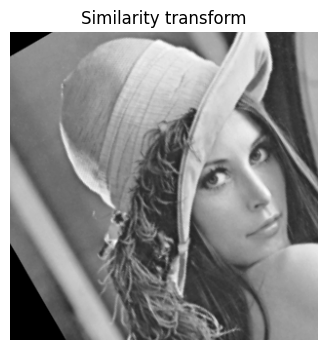

In [ ]:
# Similarity: rotate + translate + SAME scale
scale = 1.3
angle = 30
tx, ty = 40, -10

M_sim = cv2.getRotationMatrix2D((w//2, h//2), angle, scale)
M_sim[:,2] += [tx, ty]

similarity_img = cv2.warpAffine(image, M_sim, (w, h))
show("Similarity transform", similarity_img)


Аффинное преобразование — это линейное преобразование плоскости, которое может изменять углы и расстояния, но сохраняет параллельность линий. Оно включает повороты, сдвиги, масштабирование, сдвиги (shear) и их комбинации.

В этом примере оно задаётся соответствием трёх точек.

1. Исходные точки (src_pts)

Мы выбираем три точки на оригинальном изображении:

(50, 50)

(200, 50)

(50, 200)

Это три опорные точки, по которым OpenCV определяет, «как» преобразовывать изображение.

2. Целевые точки (dst_pts)

Этим трём точкам задаются новые позиции:

(70, 70)

(220, 80)

(80, 230)

Новые координаты расположены так, что создают сдвиг, наклон (shear) и небольшое масштабирование.
Таким образом мы явно задаём желаемую геометрическую деформацию изображения.

3. getAffineTransform(src_pts, dst_pts)

Эта функция вычисляет аффинную матрицу 2×3, которая единственным образом задаётся по трём парам точек.

Матрица описывает полное преобразование, которому должны следовать все пиксели изображения, чтобы исходные три точки перешли в целевые три.

4. warpAffine(image, M_affine, (w, h))

Применение аффинного преобразования ко всему изображению:

OpenCV перемещает каждый пиксель согласно вычисленной матрице,

получая искажение, включающее наклон, поворот, сдвиг и масштабирование.

Результат — изображение, где объекты:

✔ могут быть «наклонены» (shear),
✔ могут быть растянуты или сжаты по осям,
✔ могут быть повернуты и перенесены,
✔ параллельные линии остаются параллельными.


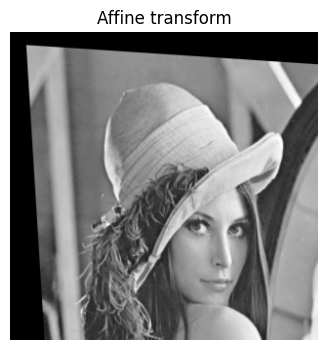

In [ ]:
# Define 3 points in the source image
src_pts = np.float32([[50,50], [200,50], [50,200]])

# Define where those points should go (strong skew)
dst_pts = np.float32([[70,70], [220,80], [80,230]])

M_affine = cv2.getAffineTransform(src_pts, dst_pts)

affine_img = cv2.warpAffine(image, M_affine, (w, h))
show("Affine transform", affine_img)


**projective transform / homography**

Проективное преобразование (гомография) — это наиболее общее преобразование плоского изображения.
Оно позволяет моделировать перспективу, то есть случаи, когда прямые линии остаются прямыми, но параллельные линии могут сходиться.

В отличие от аффинного преобразования, гомография способна корректно описывать «вид сверху», «под углом», наклон камеры, перспективные искажения.

1. Исходные точки (src_pts)

Задаются 4 точки исходного изображения — в данном примере это четыре угла кадра:

(0, 0)

(w–1, 0)

(w–1, h–1)

(0, h–1)

То есть мы берём весь прямоугольник изображения.

2. Целевые точки (dst_pts)

Каждому углу задаётся новая позиция:

(40, 30)

(w–80, 20)

(w–30, h–40)

(50, h–20)

Эти точки расположены не как прямоугольник → это создаёт перспективное искажение, при котором одна часть изображения как будто «ближе» к наблюдателю, а другая — «дальше».

3. findHomography(src_pts, dst_pts)

OpenCV вычисляет гомографию — матрицу 3×3, которая описывает проективное преобразование.

Эта матрица:

позволяет переносить произвольную точку (x, y) в новую координату,

включает в себя поворот, сдвиг, масштаб, наклон (shear),

а главное — перспективное смещение (projective distortion), которого нет в аффинной трансформации.

4. warpPerspective(image, H, (w, h))

Функция применяет гомографию ко всему изображению:

каждое значение пикселя пересчитывается через матрицу 3×3,

выполняется настоящее перспективное преобразование,

объект как будто «вращают в 3D», даже если всё происходит в плоскости.

Результат — изображение с перспективным наклоном и характерным «скошенным» видом.

**✨ Ключевое отличие**

Affine: сохраняет параллельность линий

Homography: позволяет параллельным линиям пересекаться (как в перспективе), выполняет самые общие 2D-3D-подобные преобразования

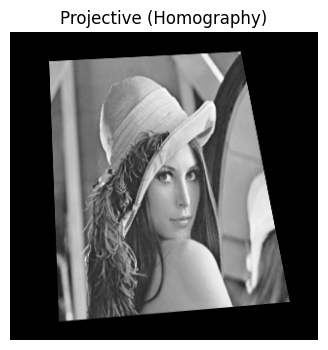

In [ ]:
# 4 points for homography
src_pts = np.float32([[0,0], [w-1,0], [w-1,h-1], [0,h-1]])
dst_pts = np.float32([[40,30], [w-80,20], [w-30,h-40], [50,h-20]])

H, _ = cv2.findHomography(src_pts, dst_pts)

homography_img = cv2.warpPerspective(image, H, (w, h))
show("Projective (Homography)", homography_img)


Детектор Харриса (OpenCV)

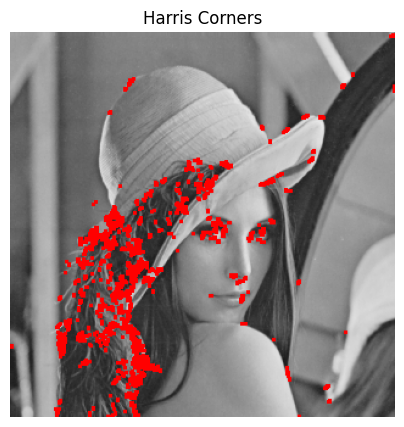

In [ ]:
# Load grayscale image
img = cv2.imread("Lenna.jpg", cv2.IMREAD_GRAYSCALE)
img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

# --- Harris detector ---
# blockSize: размер окна
# ksize: апертура оператора Собеля
# k: эмпирический коэффициент (обычно 0.04–0.06)

harris = cv2.cornerHarris(
    np.float32(img),
    blockSize=2,
    ksize=3,
    k=0.04
)

# Увеличим контраст для визуализации
harris_norm = cv2.dilate(harris, None)

# Порог: выделяем самые сильные углы
threshold = 0.01 * harris_norm.max()
corners = harris_norm > threshold

# Отметим углы красным
img_color[corners] = [0, 0, 255]  # BGR → Red

# Show result
plt.figure(figsize=(5,5))
plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
plt.title("Harris Corners")
plt.axis('off')
plt.show()

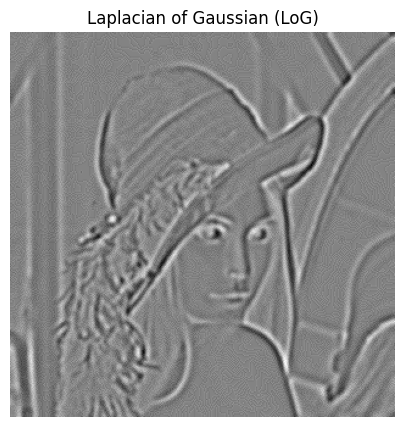

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load grayscale
img = cv2.imread("Lenna.jpg", cv2.IMREAD_GRAYSCALE)

# 1. Gaussian smoothing
sigma = 2
ksize = int(6*sigma + 1)   # стандартное правило выбора размера ядра
gauss = cv2.GaussianBlur(img, (ksize, ksize), sigma)

# 2. Laplacian
log = cv2.Laplacian(gauss, cv2.CV_64F)

plt.figure(figsize=(5,5))
plt.imshow(log, cmap="gray")
plt.title("Laplacian of Gaussian (LoG)")
plt.axis("off")
plt.show()


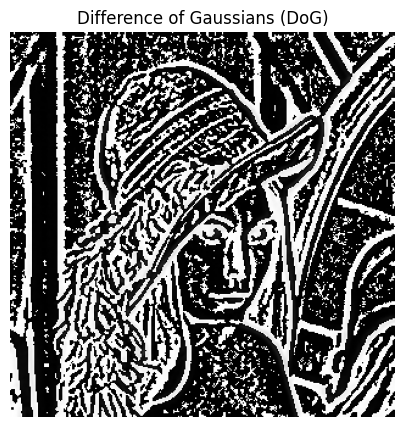

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load grayscale
img = cv2.imread("Lenna.jpg", cv2.IMREAD_GRAYSCALE)

# Two Gaussian blurs with different σ
sigma1 = 1.0
sigma2 = 2.0

ksize1 = int(6*sigma1 + 1)
ksize2 = int(6*sigma2 + 1)

G1 = cv2.GaussianBlur(img, (ksize1, ksize1), sigma1)
G2 = cv2.GaussianBlur(img, (ksize2, ksize2), sigma2)

DoG = G1 - G2

plt.figure(figsize=(5,5))
plt.imshow(DoG, cmap='gray')
plt.title("Difference of Gaussians (DoG)")
plt.axis('off')
plt.show()


**SIFT (Scale-Invariant Feature Transform)** — это детектор и дескриптор ключевых точек, устойчивый к повороту, масштабу и слабым аффинным искажениям.
Он ищет локальные экстремумы в Difference of Gaussians (DoG) по трём измерениям: x, y, scale, затем вычисляет ориентацию и строит 128-мерный дескриптор, основанный на распределении градиентов в окрестности точки.

Основные параметры cv2.SIFT_create() и их значение

sift = cv2.SIFT_create(
    nfeatures=1000,
    nOctaveLayers=3,
    contrastThreshold=0.04,
    edgeThreshold=10,
    sigma=1.6
)


| Параметр              | Значение по умолчанию | Что контролирует                                              | Как влияет                                                                       |
| --------------------- | --------------------- | ------------------------------------------------------------- | -------------------------------------------------------------------------------- |
| **nfeatures**         | `0`                   | Максимальное число возвращаемых ключевых точек                | 0 = без ограничения; больше — ограничивает количество точек                      |
| **nOctaveLayers**     | `3`                   | Число слоёв внутри каждой октавы гауссовой пирамиды           | Больше слоёв → лучше стабильность → медленнее работа                             |
| **contrastThreshold** | `0.04`                | Порог для фильтрации слабых (низкоконтрастных) ключевых точек | Меньше → больше точек, включая шум; больше → чище, но меньше точек               |
| **edgeThreshold**     | `10`                  | Фильтр точек, лежащих на длинных гранях (edge-like)           | Меньше → меньше ложных крайовых точек; больше → допускает больше точек на гранях |
| **sigma**             | `1.6`                 | Начальный параметр σ для Гауссова сглаживания                 | Больше → сильнее сглаживание на первом уровне; изменяет характер scale-space     |


Number of keypoints: 451
Descriptor shape: (451, 128)


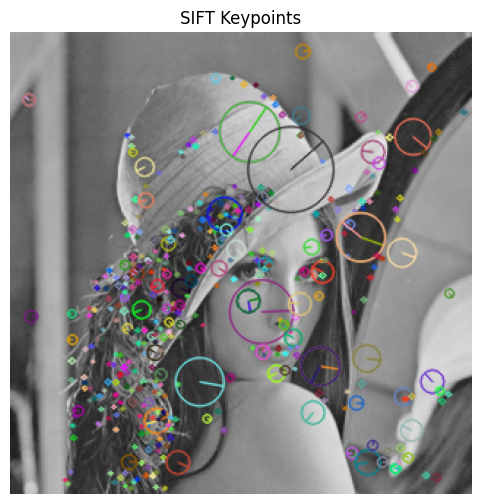

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load grayscale
img = cv2.imread("Lenna.jpg", cv2.IMREAD_GRAYSCALE)

# --- Create SIFT detector ---
sift = cv2.SIFT_create()

# --- Detect keypoints + descriptors ---
keypoints, descriptors = sift.detectAndCompute(img, None)

print("Number of keypoints:", len(keypoints))
print("Descriptor shape:", descriptors.shape)

# --- Draw keypoints ---
img_kp = cv2.drawKeypoints(
    img,
    keypoints,
    None,
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS  # рисует ориентацию и масштаб
)

plt.figure(figsize=(6,6))
plt.imshow(img_kp, cmap="gray")
plt.title("SIFT Keypoints")
plt.axis('off')
plt.show()


In [ ]:
!pip install opencv-contrib-python


cv2.drawKeypoints() — это визуализационная функция, которая рисует найденные детектором ключевые точки на изображении.Она не меняет сами keypoints, а только отображает их в удобной форме: кружками, стрелками ориентации или с масштабом, в зависимости от выбранного режима.

| Параметр      | Что означает                                                 | Что делает                                        |
| ------------- | ------------------------------------------------------------ | ------------------------------------------------- |
| **image**     | Исходное изображение (обычно цветное)                        | Поверх него будут нарисованы ключевые точки       |
| **keypoints** | Список объектов `cv2.KeyPoint`                               | Точки, которые нужно нарисовать                   |
| **outImage**  | Куда выводить результат (`None` = создать новое изображение) | OpenCV создаст новый кадр с нарисованными точками |
| **flags**     | Режим визуализации                                           | Определяет стиль отображения ключевых точек       |


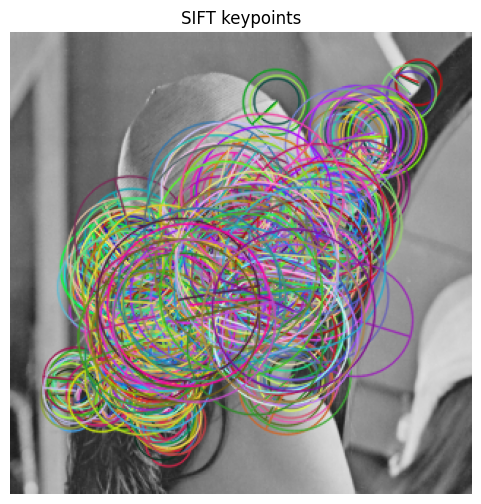

In [ ]:
img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

img_kp = cv2.drawKeypoints(
    image=img_color,
    keypoints=keypoints,
    outImage=None,
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(img_kp, cv2.COLOR_BGR2RGB))
plt.title("SIFT keypoints")
plt.axis("off")
plt.show()


**ORB (Oriented FAST and Rotated BRIEF) **— это быстрое, бесплатное и устойчивое к повороту сочетание:

FAST — детектор ключевых точек,

rBRIEF — бинарный дескриптор, построенный на BRIEF, но дополненный ориентацией.

ORB работает через гауссову пирамиду (multi-scale), поэтому устойчив к масштабу, и умеет вычислять ориентацию точки, что делает его rotation-invariant.

**Пояснение параметров cv2.ORB_create(...)**

| Параметр          | Значение в коде    | Что контролирует                                     | Пояснение                                                        |
| ----------------- | ------------------ | ---------------------------------------------------- | ---------------------------------------------------------------- |
| **nfeatures**     | `500`              | Максимальное число ключевых точек                    | ORB отберёт лучшие 500 по score                                  |
| **scaleFactor**   | `1.2`              | Коэффициент масштабирования пирамиды                 | Меньше → плотнее уровни масштаба; больше → быстрее, но грубее    |
| **nlevels**       | `8`                | Количество уровней пирамиды                          | Больше уровней → лучше для разных масштабов, но медленнее        |
| **edgeThreshold** | `31`               | Размер области, недоступной для поиска около границы | Нужно, чтобы patch BRIEF полностью помещался внутри              |
| **firstLevel**    | `0`                | Какой уровень считать начальным                      | Обычно 0; редко меняется                                         |
| **WTA_K**         | `2`                | Количество точек, сравниваемых в BRIEF               | 2 → стандарт (pairwise tests); 3 или 4 → устойчивее, но тяжелее  |
| **scoreType**     | `ORB_HARRIS_SCORE` | Метод ранжирования keypoints                         | `HARRIS_SCORE` более надёжный; `FAST_SCORE` — быстрее            |
| **patchSize**     | `31`               | Размер патча для BRIEF                               | Должен совпадать с edgeThreshold                                 |
| **fastThreshold** | `20`               | Порог FAST-детектора                                 | Меньше → больше точек, включая шум; больше → только сильные углы |


Что делает detectAndCompute(img, None)
1. detect()

ORB ищет keypoints через FAST на каждом уровне гауссовой пирамиды:

определяет координаты,

оценивает угол ориентации,

фильтрует по качеству (Harris score или FAST score).

2. compute()

Для каждой найденной точки строится:

ориентированный BRIEF-дескриптор (бинарный вектор длиной 256 бит)

учитывается поворот, поэтому ORB инвариантен к вращению

Возвращает:

keypoints — список cv2.KeyPoint

descriptors — бинарная матрица размера (N × D), где N — количество найденных и успешно описанных ключевых точек, D — длина дескриптора (у ORB = 32 байта → 256 бит)

ORB keypoints: 484
Descriptors shape: (484, 32)


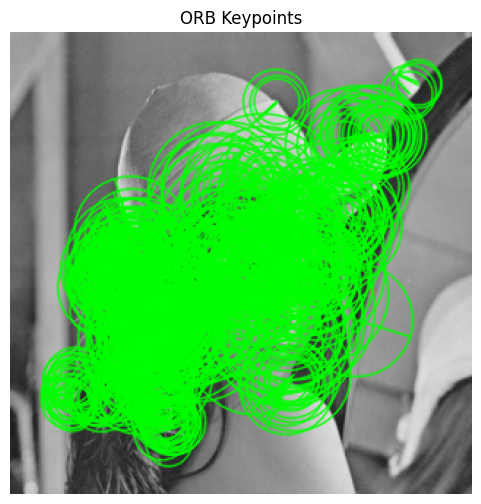

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load grayscale
img = cv2.imread("Lenna.jpg", cv2.IMREAD_GRAYSCALE)

# ORB detector + descriptor
orb = cv2.ORB_create(
    nfeatures=500,      # максимальное число ключевых точек
    scaleFactor=1.2,     # пирамидный коэффициент
    nlevels=8,           # уровни пирамиды
    edgeThreshold=31,    # область, вне которой не берём точки
    firstLevel=0,
    WTA_K=2,             # BRIEF selector
    scoreType=cv2.ORB_HARRIS_SCORE,  # или FAST_SCORE
    patchSize=31,
    fastThreshold=20
)

# Detect + compute
keypoints, descriptors = orb.detectAndCompute(img, None)

print("ORB keypoints:", len(keypoints))
print("Descriptors shape:", descriptors.shape)

# Draw keypoints
img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
img_orb = cv2.drawKeypoints(
    img_color,
    keypoints,
    None,
    color=(0,255,0),
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(img_orb, cv2.COLOR_BGR2RGB))
plt.title("ORB Keypoints")
plt.axis("off")
plt.show()


полный, цельный, рабочий пример:

✔ берём исходное изображение

✔ делаем аффинный наклон (skew / shear)
✔ на обоих изображениях ищем ключевые точки Harris

✔ строим дескрипторы (Harris сам их не даёт → используем ORB-дескрипторы на Харрис-точках)

✔ сопоставляем дескрипторы BFMatcher(Hamming)

✔ выводим численную метрику различия

 → чем ближе к 0, тем изображения «похожее»

 → растёт при искажениях

Это делается в реальных Vision-задачах:
детектор Харриса + бинарные дескрипторы + Hamming-distance matching.

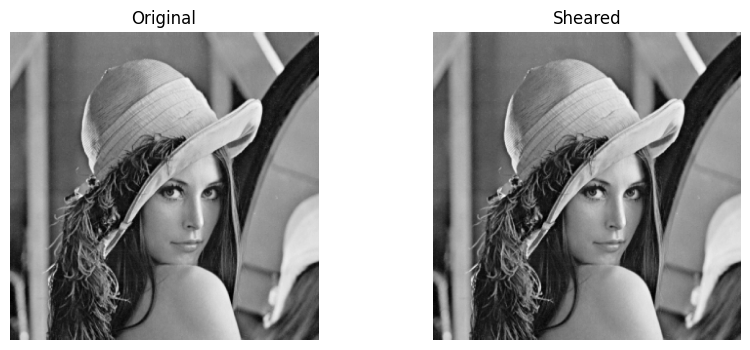

Harris keypoints img1: 6082
Harris keypoints img2: 6082
Descriptors 1: (5578, 32)
Descriptors 2: (5578, 32)
Matches found: 5578

===== METRICS =====
Mean Hamming distance: 0.0
Similarity score (0=разные, 1=одинаковые): 1.0


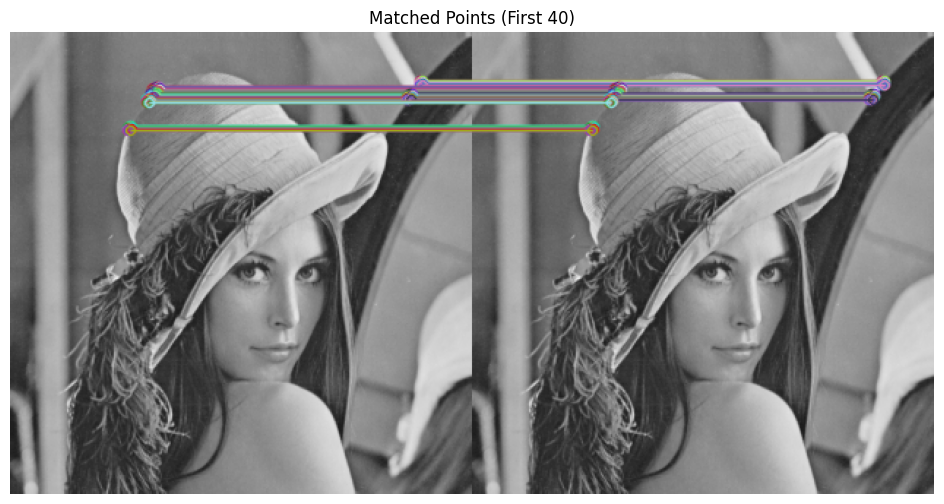

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1) Загрузка изображения
# -----------------------------
img = cv2.imread("Lenna.jpg", cv2.IMREAD_GRAYSCALE)
h, w = img.shape

# -----------------------------
# 2) Создаём трансформацию наклона (shear)
# -----------------------------
# shear_factor = 0.3
shear_factor = 0

M_shear = np.array([
    [1, shear_factor, 0],
    [0,             1, 0]
], dtype=np.float32)

img_sheared = cv2.warpAffine(img, M_shear, (w + int(shear_factor*h), h))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(img, cmap='gray'); plt.axis('off'); plt.title("Original")
plt.subplot(1,2,2); plt.imshow(img_sheared, cmap='gray'); plt.axis('off'); plt.title("Sheared")
plt.show()

# -----------------------------
# 3) Детектор Харриса → keypoints
# -----------------------------
def harris_kp(image, block_size=2, ksize=3, k=0.04, thresh=0.01):
    harris = cv2.cornerHarris(np.float32(image), block_size, ksize, k)
    harris = cv2.dilate(harris, None)
    pts = np.argwhere(harris > thresh * harris.max())

    # превращаем в список cv2.KeyPoint
    keypoints = [cv2.KeyPoint(float(x[1]), float(x[0]), 3) for x in pts]
    return keypoints

kp1 = harris_kp(img)
kp2 = harris_kp(img_sheared)

print("Harris keypoints img1:", len(kp1))
print("Harris keypoints img2:", len(kp2))

# -----------------------------
# 4) BRIEF / ORB дескрипторы
# ORB работает на произвольном наборе keypoints → идеально
# -----------------------------
orb = cv2.ORB_create()

kp1, des1 = orb.compute(img, kp1)
kp2, des2 = orb.compute(img_sheared, kp2)

print("Descriptors 1:", des1.shape)
print("Descriptors 2:", des2.shape)

# -----------------------------
# 5) Сопоставление BFMatcher(Hamming)
# -----------------------------
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)

# сортируем по расстоянию
matches = sorted(matches, key=lambda x: x.distance)

print("Matches found:", len(matches))

# -----------------------------
# 6) Метрика различия между изображениями
# -----------------------------
# Чем больше Hamming distance → тем меньше похожи изображения
# Возьмём:
#   - среднее расстояние по матчам
#   - долю хороших матчей
#   - относительная мера "похожести"
# -----------------------------

if len(matches) > 0:
    distances = np.array([m.distance for m in matches], dtype=np.float32)
    mean_dist = distances.mean()

    # нормировка 0..1
    similarity_score = 1.0 - (mean_dist / 256.0)  # 256 = максимум у ORB

    print("\n===== METRICS =====")
    print("Mean Hamming distance:", mean_dist)
    print("Similarity score (1=разные, 0=одинаковые):", similarity_score)
else:
    print("No matches → images extremely different!")

# -----------------------------
# 7) Визуализация матчей
# -----------------------------
img_matches = cv2.drawMatches(
    img, kp1,
    img_sheared, kp2,
    matches[:100], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

plt.figure(figsize=(14,6))
plt.imshow(img_matches)
plt.axis('off')
plt.title("Matched Points (First 40)")
plt.show()


Расшифровка:

Mean Hamming distance: 39.1

У ORB-дескрипторов:

диапазон расстояний от 0 до 256

на одинаковых изображениях среднее будет 0–5

при небольших аффинных искажениях обычно 20–60

расстояние ≈39 говорит:

→ изображения существенно похожи,
→ но присутствует различимое искажение (наклон).